# In this code a trasnformer model is utilized using positional encoding. The entire dataset of NGSIM dataset has been tried to be utilized by converting the time series problem into a supervised learning problem (where input is the velocity of 8 previous time steps and optput is velocity of one time step in future).

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5,6"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
# Using seaborn for pairplot.
!pip install -q seaborn
!pip install -q tensorflow

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard #Profiling the training process to identify bottlenecks

from tensorflow.keras.mixed_precision import set_global_policy # to speed up computations and reduce memory usage

2025-02-15 11:17:43.246914: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-15 11:17:43.246994: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-15 11:17:43.247034: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-15 11:17:43.257684: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# The environment setup
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [5]:
# Load the CSV file
df = pd.read_csv('../Next_Generation_Simulation__NGSIM__Vehicle_Trajectories_and_Supporting_Data_20240819.csv')

# Select the required columns
required_columns = ['Global_X', 'Global_Y', 'v_Vel', 'v_Acc', 'Global_Time', 'Vehicle_ID']
velocity_dataset = df[required_columns]

In [6]:
velocity_dataset.shape

(9455901, 6)

In [7]:
# Sort by Vehicle_ID and Global_Time
velocity_dataset_sorted = velocity_dataset.sort_values(by=['Vehicle_ID', 'Global_Time']).reset_index(drop=True)

In [8]:
velocity_dataset_sorted

,Global_X,Global_Y,v_Vel,v_Acc,Global_Time,Vehicle_ID
0,6042841.908,2133120.155,12.50,0.00,1113433136300,1
1,6042839.670,2133135.799,14.64,0.08,1113433137500,1
2,6042839.214,2133138.665,14.59,-0.54,1113433137700,1
3,6042838.525,2133142.971,14.13,-3.49,1113433138000,1
4,6042837.417,2133153.456,13.00,0.00,1113433138800,1
...,...,...,...,...,...,...
9455896,6042608.928,2134671.977,63.93,-11.20,1113433457400,3366
9455897,6042607.952,2134678.398,62.22,-11.20,1113433457500,3366
9455898,6042606.994,2134684.573,62.22,0.00,1113433457600,3366
9455899,6042606.083,2134690.504,62.22,0.00,1113433457700,3366


In [9]:
# Extract unique Vehicle_IDs and count them
unique_vehicle_ids = velocity_dataset_sorted['Vehicle_ID'].unique()
num_unique_ids = len(unique_vehicle_ids)
print(f"Number of unique Vehicle_IDs: {num_unique_ids}")

Number of unique Vehicle_IDs: 3233


In [10]:
# Function to convert a series to a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    df_s = pd.DataFrame(data)
    cols, names = [], []
    
    # Input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_s.shift(i))
        names.append(f'var1(t-{i})')
    
    # Forecast sequence (t)
    for i in range(0, n_out):
        cols.append(df_s.shift(-i))
        names.append(f'var1(t+{i})')
    
    # Combine all
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [11]:
# Convert to supervised learning problem
n_in = 8  # Number of previous time steps as input
n_out = 1  # Predict one step ahead

In [12]:
# Initialize an empty list to store the converted datasets
all_supervised_data = []

# Initialize a dictionary to store the counts
vehicle_id_counts = {}

# Loop through each unique Vehicle_ID
for vehicle_id in unique_vehicle_ids:
    # Filter data for the specific Vehicle_ID
    single_vehicle_data = velocity_dataset_sorted[velocity_dataset_sorted['Vehicle_ID'] == vehicle_id]
    
    # Extract the velocity column (you can include other columns if needed)
    velocities = single_vehicle_data['v_Vel'].values
    
    # Store the count of velocity data for the current Vehicle_ID
    vehicle_id_counts[vehicle_id] = len(velocities)
    
    # Convert to supervised learning problem
    supervised_data = series_to_supervised(velocities, n_in=n_in, n_out=n_out)
    
    # Add a column for Vehicle_ID to track which data belongs to which vehicle
    supervised_data['Vehicle_ID'] = vehicle_id
    
    # Append the converted data to the list
    all_supervised_data.append(supervised_data)

# Combine all supervised data into a single DataFrame
final_supervised_dataset = pd.concat(all_supervised_data, axis=0, ignore_index=True)

# Convert the vehicle_id_counts dictionary into a DataFrame for easier inspection or saving
vehicle_id_counts_df = pd.DataFrame(list(vehicle_id_counts.items()), columns=['Vehicle_ID', 'Velocity_Count'])

# Save or inspect the dataset
print(final_supervised_dataset.head())

   var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  \
0      12.50      14.64      14.59      14.13      13.00      13.00   
1      14.64      14.59      14.13      13.00      13.00      13.00   
2      14.59      14.13      13.00      13.00      13.00      12.99   
3      14.13      13.00      13.00      13.00      12.99       3.96   
4      13.00      13.00      13.00      12.99       3.96       3.67   

   var1(t-2)  var1(t-1)  var1(t+0)  Vehicle_ID  
0      13.00      12.99       3.96           1  
1      12.99       3.96       3.67           1  
2       3.96       3.67       3.67           1  
3       3.67       3.67       3.68           1  
4       3.67       3.68       3.64           1  


In [13]:
vehicle_id_counts_df.to_csv('vehicle_id_velocity_counts.csv', index=False)
print(vehicle_id_counts_df.head(10).to_string(index=False))

 Vehicle_ID  Velocity_Count
          1            1196
          2            4565
          3            1731
          4            2503
          5            3622
          6            1961
          7            1676
          8            2048
          9            3824
         10            3661


In [14]:
# Split the supervised data into training, validation, and test sets
n_train = int(len(final_supervised_dataset) * 0.7)
n_validation = int(len(final_supervised_dataset) * 0.15)

train_data = final_supervised_dataset[:n_train]
validation_data = final_supervised_dataset[n_train:n_train + n_validation]
test_data = final_supervised_dataset[n_train + n_validation:]

# Separate inputs (X) and outputs (y)
# Assuming the last column is 'Vehicle_ID' and the second-to-last column is the target (var1(t+0))
X_train, y_train = train_data.iloc[:, :-2].values, train_data.iloc[:, -2].values
X_validation, y_validation = validation_data.iloc[:, :-2].values, validation_data.iloc[:, -2].values
X_test, y_test = test_data.iloc[:, :-2].values, test_data.iloc[:, -2].values

In [15]:
# Reshape data for LSTM (samples, time steps, features)
# '-1' lets it automatically match the number of features(more generic), can put '1' when working with just one variable v_Vel
X_train = X_train.reshape((X_train.shape[0], n_in, -1))
X_validation = X_validation.reshape((X_validation.shape[0], n_in, -1))
X_test = X_test.reshape((X_test.shape[0], n_in, -1))

In [16]:
print(X_test.shape)
print(y_test.shape)

(1414506, 8, 1)
(1414506,)


In [17]:
print("X_validation shape:", X_validation.shape)
print("y_validation shape:", y_validation.shape)

X_validation shape: (1414505, 8, 1)
y_validation shape: (1414505,)


In [18]:
# Positional encoding function
def positional_encoding(sequence_length, d_model):
    pos = np.arange(sequence_length)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    pos_encoding = pos * angle_rates

    # Apply sine to even indices, cosine to odd indices
    pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])

    return tf.cast(pos_encoding, dtype=tf.float32)

In [19]:
# def build_transformer_model_with_positional_encoding(sequence_length, d_model, num_heads, ff_units, num_layers, output_dim):
#     inputs = Input(shape=(sequence_length, d_model))  # Input shape: (timesteps, features)

#     # Expand feature space to improve transformer performance
#     x = Dense(16, activation="relu")(inputs)

#     # Positional encoding (ensure compatibility)
#     pos_encoding = positional_encoding(sequence_length, 16)  # Now matches expanded feature space
#     x = tf.cast(x, dtype=pos_encoding.dtype) + pos_encoding
#     print(f"Positional Encoding dtype: {pos_encoding.dtype}")
#     print(f"x dtype after positional encoding: {x.dtype}")
    

#     for _ in range(num_layers):
#         # Multi-head attention
#         attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=16)(x, x)
#         attn_output = Dropout(0.1)(attn_output)
#         attn_output = LayerNormalization(epsilon=1e-6)(x + attn_output)

#         # Feedforward network
#         ffn = Dense(ff_units, activation='relu')(attn_output)
#         ffn = Dense(16)(ffn)
#         ffn = Dropout(0.1)(ffn)
#         x = LayerNormalization(epsilon=1e-6)(attn_output + ffn)

#     # Output layer
#     x = layers.GlobalAveragePooling1D()(x)
#     outputs = Dense(output_dim)(x)  # Output for prediction

#     return Model(inputs, outputs)

In [20]:
def build_transformer_model_with_positional_encoding(sequence_length, d_model, num_heads, ff_units, num_layers, output_dim):
    inputs = Input(shape=(sequence_length, d_model))  # Input shape: (timesteps, features)

    # Expand feature space to improve transformer performance
    x = Dense(32, activation="relu")(inputs)
    x = Dropout(0.1)(x)  # Dropout after feature expansion

    # Positional encoding (ensure compatibility)
    pos_encoding = positional_encoding(sequence_length, 32)  # Now matches expanded feature space
    x = tf.cast(x, dtype=pos_encoding.dtype) + pos_encoding

    for _ in range(num_layers):
        # Multi-head attention
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=32)(x, x)
        attn_output = Dropout(0.1)(attn_output)  # Dropout after attention
        attn_output = LayerNormalization(epsilon=1e-6)(x + attn_output)

        # Feedforward network
        ffn = Dense(ff_units, activation='relu')(attn_output)
        ffn = Dense(32)(ffn)
        ffn = Dropout(0.1)(ffn)  # Dropout after feedforward network
        x = LayerNormalization(epsilon=1e-6)(attn_output + ffn)

    # Apply dropout before global pooling to prevent overfitting
    x = Dropout(0.1)(x)
    x = layers.GlobalAveragePooling1D()(x)

    # Output layer
    outputs = Dense(output_dim)(x)  # Output for prediction

    return Model(inputs, outputs)

In [21]:
# # Define model parameters
# sequence_length = X_train.shape[1]  # Number of timesteps (n_in)
# d_model = X_train.shape[2]  # Number of features (1 in this case)
# output_dim = 1  # Predicting a single value (y)

# transformer_model = build_transformer_model_with_positional_encoding(
#     sequence_length=sequence_length,
#     d_model=d_model,
#     num_heads=8,        
#     ff_units=64,        # Hidden layer size
#     num_layers=4,       
#     output_dim=output_dim
# )

In [22]:
sequence_length = X_train.shape[1]  # Number of timesteps (n_in)
original_d_model = X_train.shape[2]  # Original number of features (1 in this case)
expanded_d_model = 32  # New feature space after Dense layer

output_dim = 1  # Predicting a single value (y)

transformer_model = build_transformer_model_with_positional_encoding(
    sequence_length=sequence_length,
    d_model=expanded_d_model,  # Use expanded feature space
    num_heads=8,        
    ff_units=128,        # Hidden layer size
    num_layers=6,       
    output_dim=output_dim
)

2025-02-15 11:45:52.902012: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-02-15 11:45:52.909240: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30371 MB memory:  -> device: 0, name: Tesla V100-SXM3-32GB, pci bus id: 0000:59:00.0, compute capability: 7.0
2025-02-15 11:45:52.909682: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-02-15 11:45:52.918244: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30519 MB memory:  -> device: 1, name: Tesla V100-SXM3-32GB, pci bus id: 0000:5c:00.0, compute capability: 7.0


In [23]:
# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# TensorBoard callback (to identify bottlenecks)
# tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=1)
tensorboard_callback = TensorBoard(log_dir="./logs", profile_batch=0)

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=1000,
    decay_rate=0.9
)

# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipvalue=1.0)
# transformer_model.compile(optimizer=optimizer, loss='mse')

# # Set mixed precision policy to float16
# set_global_policy('mixed_float16')

# Explicitly setting it back to float32
set_global_policy('float32')

# Compile the model with the appropriate optimizer

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
transformer_model.compile(optimizer=optimizer, loss='mse')

# transformer_model.compile(optimizer='adam', loss='mse')

In [ ]:
# # Before training, verify that the dataset returns correctly shaped batches
# for batch in train_dataset.take(1):
#     print("Batch X shape:", batch[0].shape)  # Should be (batch_size, 8, 1)
#     print("Batch y shape:", batch[1].shape)  # Should be (batch_size, 1)

In [24]:
# Create subsets of training and validation data
train_subset_size = 60000  # Adjust size as needed
val_subset_size = 12000     # Adjust size as needed

small_X_train = X_train[:train_subset_size]
small_y_train = y_train[:train_subset_size]
small_X_validation = X_validation[:val_subset_size]
small_y_validation = y_validation[:val_subset_size]

# # Create tf.data datasets
# def create_tf_data(X, y, batch_size=16, shuffle=True):
#     dataset = tf.data.Dataset.from_tensor_slices((X, y))
#     if shuffle:
#         dataset = dataset.shuffle(buffer_size=len(X))  # Shuffle dataset
#     dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)  # Batch and prefetch for efficiency
#     return dataset

def create_tf_data(X, y, batch_size=32, shuffle=True):
    X_expanded = np.repeat(X, 32, axis=-1)  # Expand feature dimension (1 → 32)
    dataset = tf.data.Dataset.from_tensor_slices((X_expanded.astype(np.float32), y.astype(np.float32)))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))  
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

batch_size = 32

# Training and validation datasets
train_dataset = create_tf_data(small_X_train, small_y_train, batch_size=batch_size, shuffle=True)
validation_dataset = create_tf_data(small_X_validation, small_y_validation, batch_size=batch_size, shuffle=False)

# Train the model
history = transformer_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,  # Use fewer epochs for debugging
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/20


2025-02-15 11:46:31.888649: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f772d105f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-15 11:46:31.888703: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM3-32GB, Compute Capability 7.0
2025-02-15 11:46:31.888713: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla V100-SXM3-32GB, Compute Capability 7.0
2025-02-15 11:46:31.897637: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-15 11:46:31.997875: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-15 11:46:32.097936: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 [==============================] - 125s 53ms/step - loss: 175.4754 - val_loss: 19.9069
Epoch 2/20
1875/1875 [==============================] - 95s 51ms/step - loss: 14.3208 - val_loss: 16.4341
Epoch 3/20
1875/1875 [==============================] - 103s 55ms/step - loss: 11.1928 - val_loss: 10.8248
Epoch 4/20
1875/1875 [==============================] - 94s 50ms/step - loss: 10.1789 - val_loss: 11.6823
Epoch 5/20
1875/1875 [==============================] - 92s 49ms/step - loss: 9.4757 - val_loss: 10.8660
Epoch 6/20
1875/1875 [==============================] - 94s 50ms/step - loss: 9.0445 - val_loss: 12.6243
Epoch 7/20
1875/1875 [==============================] - 97s 51ms/step - loss: 8.8272 - val_loss: 9.3644
Epoch 8/20
1875/1875 [==============================] - 102s 54ms/step - loss: 8.4313 - val_loss: 13.0999
Epoch 9/20
1875/1875 [==============================] - 91s 48ms/step - loss: 8.3445 - val_loss: 10.6292
Epoch 10/20
1875/1875 [==============================] - 10

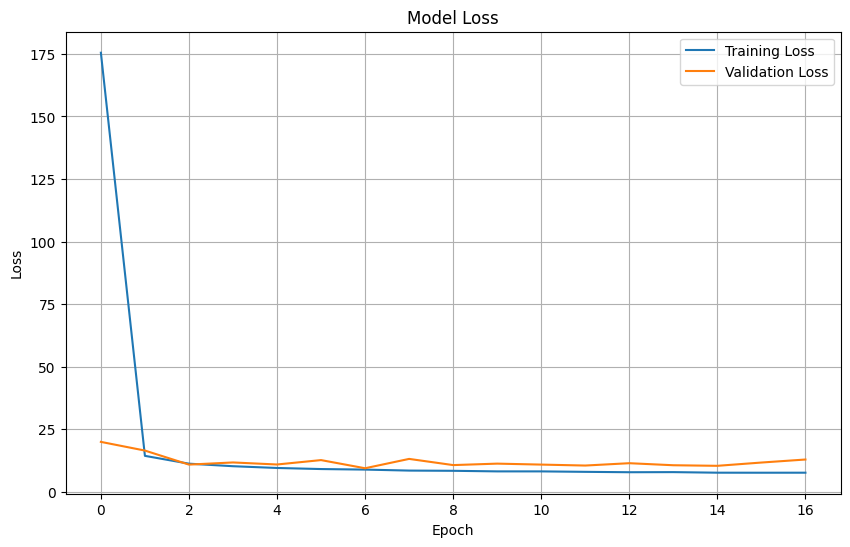

In [25]:
# Plotting training & validation loss curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history.get('val_loss'), label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [26]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Model output shape (from summary):")
transformer_model.summary()

X_test shape: (1414506, 8, 1)
y_test shape: (1414506,)
Model output shape (from summary):
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8, 32)]              0         []                            
                                                                                                  
 dense (Dense)               (None, 8, 32)                1056      ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 8, 32)                0         ['dense[0][0]']               
                                                                                                  
 tf.cast (TFOpLambda)        (None, 8, 32)                0         ['dropout[0][0]']             
    

 tf.__operators__.add_5 (TF  (None, 8, 32)                0         ['layer_normalization_4[0][0]'
 OpLambda)                                                          , 'dropout_6[0][0]']          
                                                                                                  
 layer_normalization_5 (Lay  (None, 8, 32)                64        ['tf.__operators__.add_5[0][0]
 erNormalization)                                                   ']                            
                                                                                                  
 multi_head_attention_3 (Mu  (None, 8, 32)                33568     ['layer_normalization_5[0][0]'
 ltiHeadAttention)                                                  , 'layer_normalization_5[0][0]
                                                                    ']                            
                                                                                                  
 dropout_7

 yerNormalization)                                                  ]']                           
                                                                                                  
 dropout_13 (Dropout)        (None, 8, 32)                0         ['layer_normalization_11[0][0]
                                                                    ']                            
                                                                                                  
 global_average_pooling1d (  (None, 32)                   0         ['dropout_13[0][0]']          
 GlobalAveragePooling1D)                                                                          
                                                                                                  
 dense_13 (Dense)            (None, 1)                    33        ['global_average_pooling1d[0][
                                                                    0]']                          
          

In [27]:
train_loss = transformer_model.evaluate(train_dataset, verbose=1)
print(f"Training Subset Loss: {train_loss}")

val_loss = transformer_model.evaluate(validation_dataset, verbose=1)
print(f"Validation Subset Loss: {val_loss}")

1875/1875 [==============================] - 25s 13ms/step - loss: 12.4148
Training Subset Loss: 12.414793968200684
375/375 [==============================] - 5s 14ms/step - loss: 9.3644
Validation Subset Loss: 9.364402770996094


In [30]:
# Evaluate the model on a subset of the test dataset
test_subset_size = 5000  # or any number you prefer
small_X_test = X_test[:test_subset_size]
small_y_test = y_test[:test_subset_size]

# Expand feature dimension from 1 to 16
small_X_test_expanded = np.repeat(small_X_test, 32, axis=-1).astype(np.float32)

test_loss = transformer_model.evaluate(small_X_test_expanded, small_y_test, verbose=1)
print(f"Test Subset Loss: {test_loss}")

# Compute RMSE if needed
rmse = np.sqrt(test_loss)
print(f"Test Subset RMSE: {rmse:.4f}")

157/157 [==============================] - 2s 10ms/step - loss: 4.2621
Test Subset Loss: 4.262102127075195
Test Subset RMSE: 2.0645


4/4 [==============================] - 1s 9ms/step


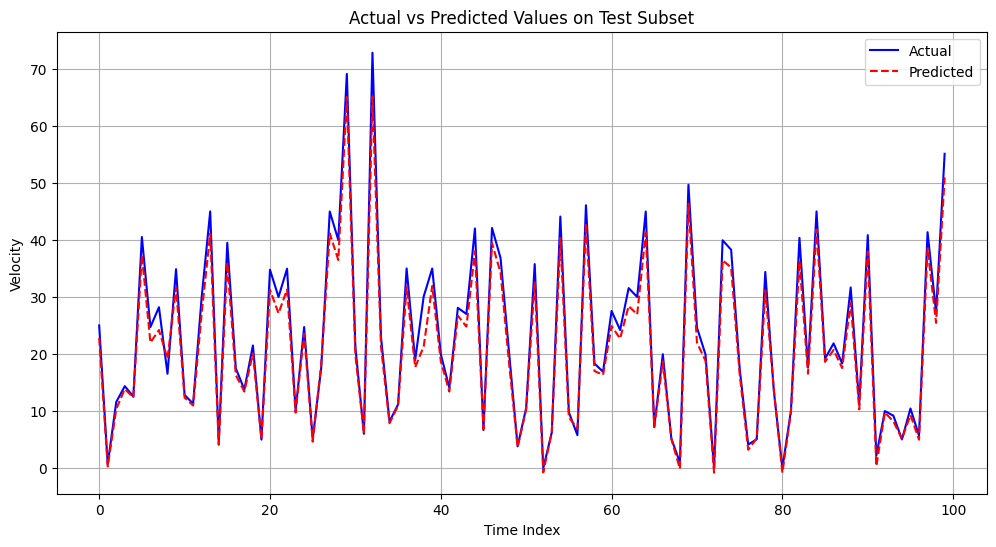

In [31]:
# Define the number of test samples you want to use for prediction
subset_size = 100  # for example, 1000 samples

# Randomly select indices from the test set
random_indices = np.random.choice(len(X_test), size=subset_size, replace=False)

# Create the test subset (using the original X_test shape)
X_test_subset = X_test[random_indices]
y_test_subset = y_test[random_indices]

# Since your model expects input with shape (batch, 8, 16),
# expand the feature dimension from 1 to 16 using np.repeat
X_test_subset_expanded = np.repeat(X_test_subset, 32, axis=-1).astype(np.float32)

# Get predictions from the trained model on the test subset
predictions = transformer_model.predict(X_test_subset_expanded, verbose=1)

# If predictions come out as shape (subset_size, 1), flatten them for plotting
predicted_values = predictions.flatten()

# Create time indices for plotting (or you can use the sample index)
time_indices = np.arange(len(y_test_subset))

# Create a DataFrame to store actual and predicted values
results_df = pd.DataFrame({
    'Index': time_indices,
    'Actual': y_test_subset,
    'Predicted': predicted_values
})

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(results_df['Index'], results_df['Actual'], label='Actual', color='blue')
plt.plot(results_df['Index'], results_df['Predicted'], label='Predicted', color='red', linestyle='--')
plt.xlabel('Time Index')
plt.ylabel('Velocity')
plt.title('Actual vs Predicted Values on Test Subset')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
transformer_model.save("transformer_(990KB).keras")